In [90]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import spacy
from sklearn.preprocessing import LabelEncoder
import tqdm
import re
import kshingle as ks
from datasketch import MinHashLSH, MinHash, MinHashLSHForest
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

#import operator 
from tqdm import tqdm

*DATA VISUALIZATION*

Here I define the group distribution function, which allows us to plot the frequency of a certain value within the groups. Counts value are normalized w.r.t. the number of participants in each group. 

In [54]:
def group_across_value_normalized(df, value_name, x_size=14, y_size=5, bar_width=0.10, title='Frequency of {value_name} over Groups', order_legend=False):
    
    nam = title.format(value_name=value_name)
    groups = df['Group'].unique()
    value = df[value_name].unique()
    
    if order_legend:
        value = np.sort(value)

    grouped = df.groupby([value_name, 'Group']).size().reset_index(name='Counts')

    total_members = df['Group'].value_counts().reset_index()
    total_members.columns = ['Group', 'Members']

    # Plot------------------------------------------------------------------------------------
    plt.figure(figsize=(x_size, y_size))
    index = np.arange(len(groups))

    for i, val in enumerate(value):
        value_data = grouped[grouped[value_name] == val]
        counts = []
        for group in groups:
            group_count = value_data[value_data['Group'] == group]['Counts'].sum()
            group_members = total_members[total_members['Group'] == group]['Members'].iloc[0]
            normalized_count = group_count / group_members
            counts.append(normalized_count)
        # Plot the bar
        plt.bar(index + i * bar_width, counts, bar_width, label=f'{value_name}: {val}')

    #title and labels
    plt.title(nam)
    plt.ylabel('Normalized Counts')
    plt.xlabel('Group')
    plt.xticks(index + bar_width / 2 * (len(value) - 1), groups)  # Set the position of the x-ticks
    plt.xticks(rotation=45)  # Rotate group names
    
    #legend
    if order_legend:
        handles, labels = plt.gca().get_legend_handles_labels()
        labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
        plt.legend(handles, labels)
    else:
        plt.legend()

    plt.tight_layout()
    plt.show()

Print some statistics of the dataset. Here we print statistichs of the **EXCEL file**

In [55]:
csv_file_path = 'corpus-ground_truth.xls'
df = pd.read_excel(csv_file_path, sheet_name=1)

Now we plot the piechart of categories

/var/folders/9p/qnbck1y55d53yx4yf8hdc7jw0000gn/T/ipykernel_35095/198739880.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.pie([categories[0], categories[1], categories[2], categories[3]],labels=labels,colors=colors)


([<matplotlib.patches.Wedge at 0x295efc350>,
 [Text(0.33991867422268784, 1.0461621742897658, 'non'),
  Text(-1.0999999999999988, -5.149471622296949e-08, 'cut'),
  Text(-0.33991862524830174, -1.0461621902025062, 'light'),
  Text(0.8899187482945414, -0.6465637025335375, 'heavy')])

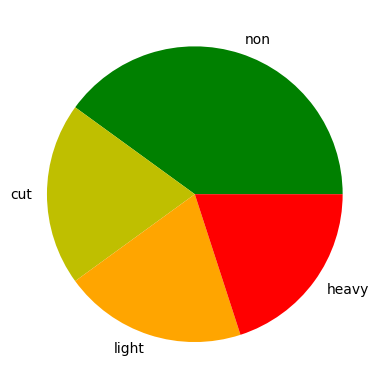

In [55]:
categories = df['Category'].value_counts()
labels = ['non', 'cut', 'light', 'heavy']
colors = ['g', 'y', 'orange', 'r' ]
plt.pie([categories[0], categories[1], categories[2], categories[3]],labels=labels,colors=colors)

Then, we wanted to see the distribution of native and non-native speaker among each group

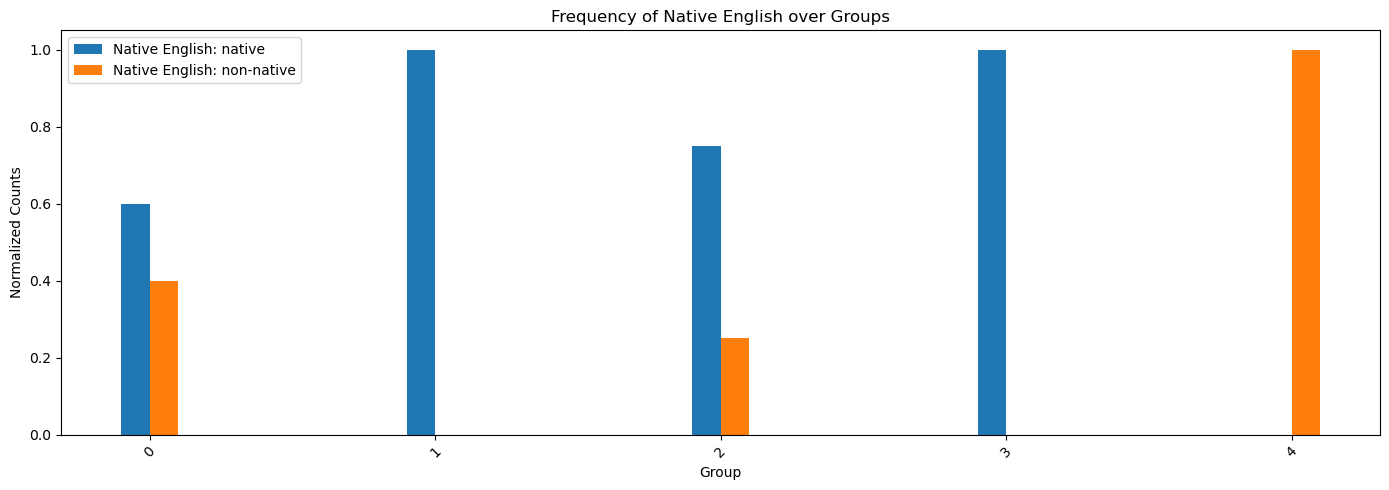

In [60]:
group_across_value_normalized(df,'Native English')

Then, we head to plot distribution of Knowledge, Difficulty and Category over groups

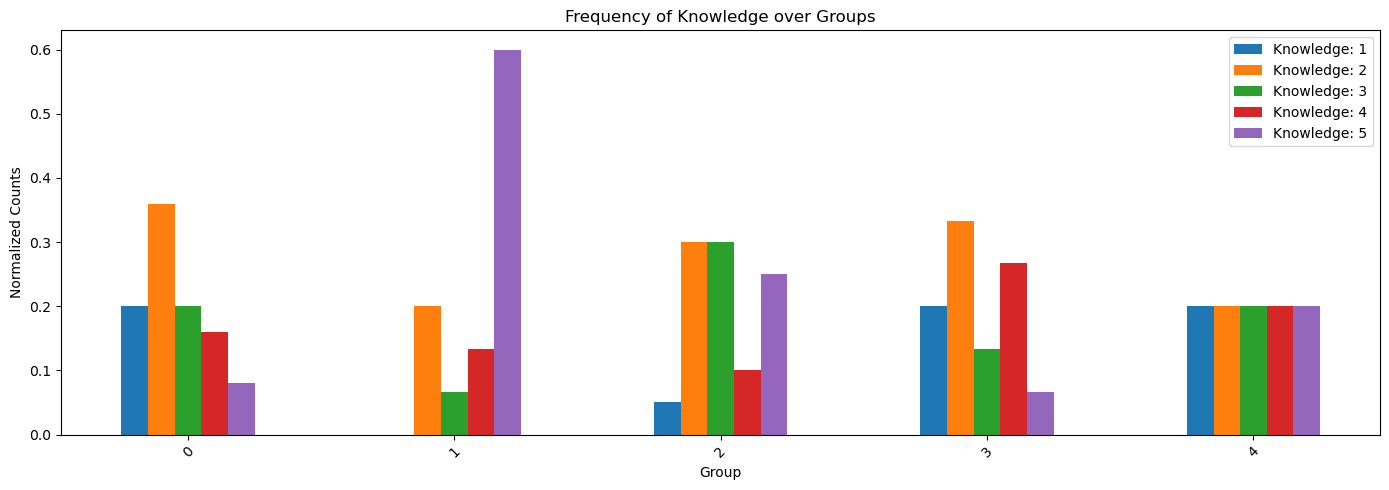

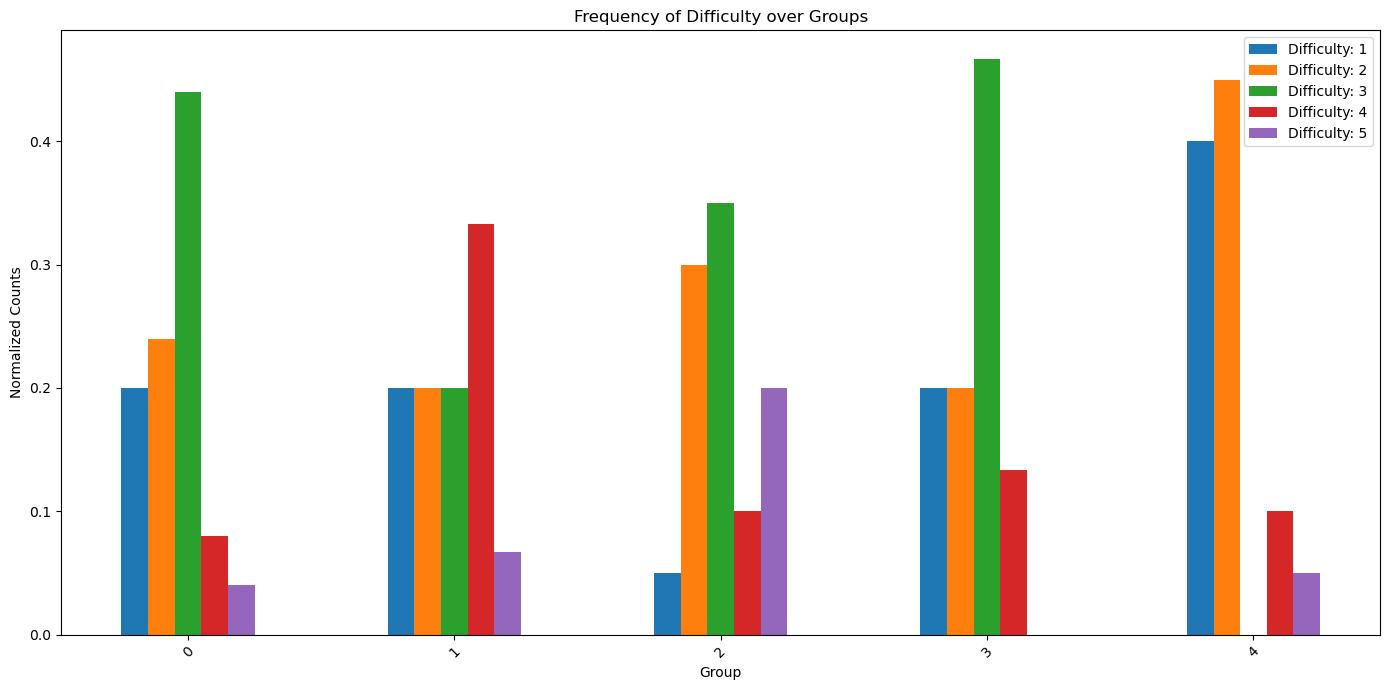

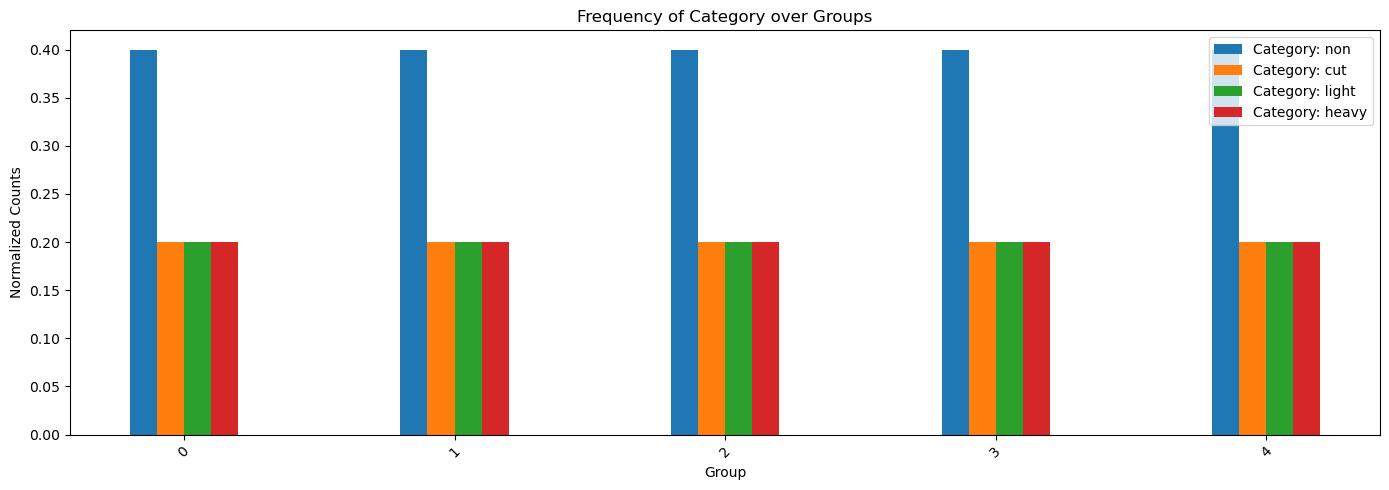

In [59]:
group_across_value_normalized(df,'Knowledge', order_legend=True)
group_across_value_normalized(df,'Difficulty', y_size=7, order_legend=True)
group_across_value_normalized(df,'Category')

Here we plot the correlation plot between the variables of our database.

0     0
1     0
2     0
3     0
4     0
     ..
90    1
91    1
92    1
93    1
94    1
Name: Native English_, Length: 95, dtype: int64
0     0
1     1
2     2
3     3
4     4
     ..
90    0
91    1
92    2
93    3
94    4
Name: Task_, Length: 95, dtype: int64
                    Category_  Native English_         Task_  Knowledge  \
Category_        1.000000e+00     1.447354e-16 -8.297271e-02  -0.032903   
Native English_  1.447354e-16     1.000000e+00  1.389443e-16  -0.236124   
Task_           -8.297271e-02     1.389443e-16  1.000000e+00   0.157367   
Knowledge       -3.290271e-02    -2.361243e-01  1.573672e-01   1.000000   
Difficulty       1.843668e-01    -3.577523e-01  2.723921e-01   0.333781   

                 Difficulty  
Category_          0.184367  
Native English_   -0.357752  
Task_              0.272392  
Knowledge          0.333781  
Difficulty         1.000000  


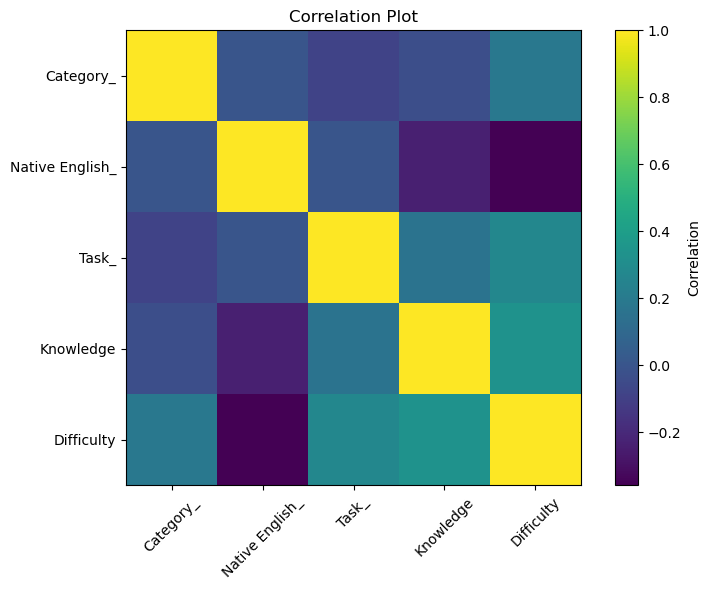

In [72]:
label_encoder = LabelEncoder()
df['Category_'] = label_encoder.fit_transform(df['Category'])
print(df['Native English_'])
print(df['Task_'])
df['Native English_'] = label_encoder.fit_transform(df['Native English'])
df['Task_'] = label_encoder.fit_transform(df['Task'])

df_correlation = df[['Category_',"Native English_","Task_",'Knowledge', 'Difficulty']].corr()
print(df_correlation)

# Plot------------------------------------------------------------
plt.style.use('default')
plt.figure(figsize=(8, 6))
plt.imshow(df_correlation, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Correlation')
plt.title('Correlation Plot')
plt.xticks(range(len(df_correlation)), df_correlation.columns, rotation=45)
plt.yticks(range(len(df_correlation)), df_correlation.columns)
plt.tight_layout()
plt.savefig('correlation_plt.png', dpi=300)
plt.show()

non = 3, cut=0 , light=2 , heavy=1

*DATA PRE-PROCESSING*

At first we create a dataframe from the excel file. We remove Group Person Task Knowledge Difficulty 

In [61]:
#import the csv file and create a DataFrame containing it. This code cell is redudant (is here only for convenience)
csv_file_path = 'corpus-ground_truth.xls'
df = pd.read_excel(csv_file_path, sheet_name=1)

In [62]:

df = df.drop(['Group', 'Person', 'Native English', 'Knowledge', 'Difficulty'], axis=1)
df = df.replace({'Category': {'non': 0, 'heavy': 1, 'light': 2, 'cut': 3}})

df['Class'] = df['Category']

df.loc[df['Class']>0, 'Class']=1

df

/var/folders/9p/qnbck1y55d53yx4yf8hdc7jw0000gn/T/ipykernel_70593/3455281999.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({'Category': {'non': 0, 'heavy': 1, 'light': 2, 'cut': 3}})


,File,Task,Category,Class
0,g0pA_taska.txt,a,0,0
1,g0pA_taskb.txt,b,3,1
2,g0pA_taskc.txt,c,2,1
3,g0pA_taskd.txt,d,1,1
4,g0pA_taske.txt,e,0,0
...,...,...,...,...
90,g4pE_taska.txt,a,1,1
91,g4pE_taskb.txt,b,2,1
92,g4pE_taskc.txt,c,3,1
93,g4pE_taskd.txt,d,0,0


Then we want to get the groundtruth files and add them to the dataframe

In [63]:
def get_paths_from_current_dir(input_path, ending = "txt"):
    
    list_of_paths = []
    for root, dirs, files in os.walk(input_path, topdown=False):
        for name in files:
            if name.endswith(ending):  
                list_of_paths.append((os.path.join(root, name)))
    list_of_paths.sort()
   # print(f'list of first 5 paths: {list_of_paths}')
    return list_of_paths


In [64]:
file_path = get_paths_from_current_dir('./corpus-20090418_or', ending = "txt")

new_rows = []

for i, path in enumerate(file_path):
    if i <= 94:
        df.loc[i, 'File'] = str(path)
    else:
        index = path.index(".txt")
        new_rows.append({'File': str(path), 'Task': path[index - 1] ,'Category': -1, 'Class': 0})

if new_rows:
    new_df = pd.DataFrame(new_rows)
    df = pd.concat([df, new_df], ignore_index=True)

df

,File,Task,Category,Class
0,./corpus-20090418_or/g0pA_taska.txt,a,0,0
1,./corpus-20090418_or/g0pA_taskb.txt,b,3,1
2,./corpus-20090418_or/g0pA_taskc.txt,c,2,1
3,./corpus-20090418_or/g0pA_taskd.txt,d,1,1
4,./corpus-20090418_or/g0pA_taske.txt,e,0,0
...,...,...,...,...
95,./corpus-20090418_or/orig_taska.txt,a,-1,0
96,./corpus-20090418_or/orig_taskb.txt,b,-1,0
97,./corpus-20090418_or/orig_taskc.txt,c,-1,0
98,./corpus-20090418_or/orig_taskd.txt,d,-1,0


Now, we aim to append to the dataframe a tokenized text

In [65]:
def tokenize_with_spacy(sentences, nlp):
    tokenized_pairs = []
    allowed_characters = re.escape("?.!,-'")

    for sentence in sentences:
        sentence = re.sub(r'\s+', ' ', re.sub(rf'[^a-zA-Z0-9{allowed_characters}\s]', '', 
                                       re.sub(r'--+', ' ', sentence)))
        tokenized_sentence = nlp(sentence)

        tokenized_pairs.append([token.text.lower() for token in tokenized_sentence]) 
    return tokenized_pairs

In [66]:
def text_processor(data_file, nlp):
    text= ''
    for line in data_file:
        tokenized_line = tokenize_with_spacy([line.strip()], nlp)
        
        if tokenized_line and isinstance(tokenized_line[0], list):
            tokenized_line = [token for sublist in tokenized_line for token in sublist]
            
        text += " " + " ".join(tokenized_line).strip()
    
    return text

In [67]:
nlp = spacy.load('en_core_web_sm', disable=["tagger", "parser", "ner", "lemmatizer"])

df['Text'] = None  

for index, file_path in df['File'].items():
    try:   
        with open(file_path, 'r', encoding='utf-8') as file:
            data_file = file.readlines()  # Read file content
    except UnicodeDecodeError:
        
        with open(file_path, 'r', encoding='ISO-8859-1') as file:
            data_file = file.readlines()  # Read file content using a different encoding

    
    text = text_processor(data_file, nlp)

   
    df.at[index, 'Text'] = text
    
df

,File,Task,Category,Class,Text
0,./corpus-20090418_or/g0pA_taska.txt,a,0,0,inheritance is a basic concept of object - or...
1,./corpus-20090418_or/g0pA_taskb.txt,b,3,1,pagerank is a link analysis algorithm used by...
2,./corpus-20090418_or/g0pA_taskc.txt,c,2,1,"the vector space model also called , term vec..."
3,./corpus-20090418_or/g0pA_taskd.txt,d,1,1,bayes theorem was names after rev thomas baye...
4,./corpus-20090418_or/g0pA_taske.txt,e,0,0,dynamic programming is an algorithm design te...
...,...,...,...,...,...
95,./corpus-20090418_or/orig_taska.txt,a,-1,0,"in object - oriented programming , inheritanc..."
96,./corpus-20090418_or/orig_taskb.txt,b,-1,0,pagerank is a link analysis algorithm used by...
97,./corpus-20090418_or/orig_taskc.txt,c,-1,0,vector space model or term vector model is an...
98,./corpus-20090418_or/orig_taskd.txt,d,-1,0,"in probability theory , bayes ' theorem often..."


Now we want to split the data between test and training set

In [68]:
import operator 

In [69]:
def create_datatype(df, train_value, test_value, datatype_var, compare_dfcolumn, operator_of_compare, value_of_compare,
                    sampling_number, sampling_seed):
    
    df_subset = df[operator_of_compare(df[compare_dfcolumn], value_of_compare)]
    df_subset = df_subset.drop(columns = [datatype_var])
    
    df_subset.loc[:, datatype_var] = train_value
    
   
    df_sampled = df_subset.groupby(['Task', compare_dfcolumn], group_keys=False).apply(lambda x: x.sample(min(len(x), sampling_number), random_state = sampling_seed))
    df_sampled = df_sampled.drop(columns = [datatype_var])
  
    df_sampled.loc[:, datatype_var] = test_value
   
    for index in df_sampled.index: 
        df_subset.loc[index, datatype_var] = test_value

    for index in df_subset.index:
        df.loc[index, datatype_var] = df_subset.loc[index, datatype_var]


In [70]:
def train_test_dataframe(clean_df, random_seed=100):
    
    new_df = clean_df.copy()
    new_df.loc[:,'Datatype'] = 0

    create_datatype(new_df, 1, 2, 'Datatype', 'Category', operator.gt, 0, 1, random_seed)

    create_datatype(new_df, 1, 2, 'Datatype', 'Category', operator.eq, 0, 2, random_seed)
    
    mapping = {0:'orig', 1:'train', 2:'test'} 

    new_df.Datatype = [mapping[item] for item in new_df.Datatype] 

    return new_df


In [74]:
random_seed = 42

complete_df_1 = train_test_dataframe(df, random_seed=random_seed)

complete_df_1

/var/folders/9p/qnbck1y55d53yx4yf8hdc7jw0000gn/T/ipykernel_70593/1683358470.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df_subset.groupby(['Task', compare_dfcolumn], group_keys=False).apply(lambda x: x.sample(min(len(x), sampling_number), random_state = sampling_seed))
/var/folders/9p/qnbck1y55d53yx4yf8hdc7jw0000gn/T/ipykernel_70593/1683358470.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this 

,File,Task,Category,Class,Text,Datatype
0,./corpus-20090418_or/g0pA_taska.txt,a,0,0,inheritance is a basic concept of object - or...,train
1,./corpus-20090418_or/g0pA_taskb.txt,b,3,1,pagerank is a link analysis algorithm used by...,test
2,./corpus-20090418_or/g0pA_taskc.txt,c,2,1,"the vector space model also called , term vec...",train
3,./corpus-20090418_or/g0pA_taskd.txt,d,1,1,bayes theorem was names after rev thomas baye...,train
4,./corpus-20090418_or/g0pA_taske.txt,e,0,0,dynamic programming is an algorithm design te...,test
...,...,...,...,...,...,...
95,./corpus-20090418_or/orig_taska.txt,a,-1,0,"in object - oriented programming , inheritanc...",orig
96,./corpus-20090418_or/orig_taskb.txt,b,-1,0,pagerank is a link analysis algorithm used by...,orig
97,./corpus-20090418_or/orig_taskc.txt,c,-1,0,vector space model or term vector model is an...,orig
98,./corpus-20090418_or/orig_taskd.txt,d,-1,0,"in probability theory , bayes ' theorem often...",orig


Now we split the dataset in two parts: 
- new_df_original. This contains only the original groundtruth files
- complete_df. This contains all the documents that may be plagiarised

In [76]:
new_df_original = complete_df_1[complete_df_1['Datatype'] == 'orig'].reset_index(drop=True)
complete_df = complete_df_1[complete_df_1['Datatype'] != 'orig']

new_df_original

,File,Task,Category,Class,Text,Datatype
0,./corpus-20090418_or/orig_taska.txt,a,-1,0,"in object - oriented programming , inheritanc...",orig
1,./corpus-20090418_or/orig_taskb.txt,b,-1,0,pagerank is a link analysis algorithm used by...,orig
2,./corpus-20090418_or/orig_taskc.txt,c,-1,0,vector space model or term vector model is an...,orig
3,./corpus-20090418_or/orig_taskd.txt,d,-1,0,"in probability theory , bayes ' theorem often...",orig
4,./corpus-20090418_or/orig_taske.txt,e,-1,0,"in mathematics and computer science , dynamic...",orig


Now we insert into the dataframe jaccard similarity given by k-shingles sets, n-grams similarity and minhash similarity

In [79]:
def calculate_similarity_ngram(a_text,org_text,n):
 
    counts = CountVectorizer(analyzer='word', ngram_range=(n,n))

    ngrams = counts.fit_transform([a_text, org_text])

    ngram_array = ngrams.toarray()
    
    return sum(np.amin(ngram_array,axis=0))/sum(ngram_array[0])

In [80]:
def calculate_shingle_similarity(ans_text, origin_text):
    
    data_shingle = ks.shingleset_range(ans_text, 3,6)
    data_org_shing = ks.shingleset_range(origin_text,3,6)
    intersection = len(data_shingle.intersection(data_org_shing))
    union = len(data_shingle.union(data_org_shing))
    
    return intersection / union

In [81]:
def calculate_minhash_similarity(ans_text, org_text):
    
    m1, m2 = MinHash(num_perm=128), MinHash(num_perm=128)
    for d in ans_text:
        m1.update(d.encode('utf8'))
    for d in org_text:
        m2.update(d.encode('utf8'))
    #print("Estimated Jaccard for data1 and data2 is", m1.jaccard(m2))
    return m1.jaccard(m2)

In [84]:
for i in new_df_original.index:
    org_file = new_df_original.loc[i, 'Text']
    task = new_df_original.loc[i, 'Task']

    for i in complete_df.index:
        file = complete_df["Text"].values[i]
        task_ans = complete_df.loc[i, 'Task']
        if task_ans == task:
            complete_df.loc[i, 'shingle'] = calculate_shingle_similarity(file,org_file)
            complete_df.loc[i, 'ngram'] = calculate_similarity_ngram(file,org_file,8)
            complete_df.loc[i, 'minhash'] = calculate_minhash_similarity(file,org_file)
complete_df

/var/folders/9p/qnbck1y55d53yx4yf8hdc7jw0000gn/T/ipykernel_70593/4233321410.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete_df.loc[i, 'ngram'] = calculate_similarity_ngram(file,org_file,8)
/var/folders/9p/qnbck1y55d53yx4yf8hdc7jw0000gn/T/ipykernel_70593/4233321410.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete_df.loc[i, 'minhash'] = calculate_minhash_similarity(file,org_file)


,File,Task,Category,Class,Text,Datatype,shingle,ngram,minhash
0,./corpus-20090418_or/g0pA_taska.txt,a,0,0,inheritance is a basic concept of object - or...,train,0.143566,0.000000,0.812500
1,./corpus-20090418_or/g0pA_taskb.txt,b,3,1,pagerank is a link analysis algorithm used by...,test,0.463339,0.857895,0.718750
2,./corpus-20090418_or/g0pA_taskc.txt,c,2,1,"the vector space model also called , term vec...",train,0.602499,0.265116,0.859375
3,./corpus-20090418_or/g0pA_taskd.txt,d,1,1,bayes theorem was names after rev thomas baye...,train,0.257691,0.027778,0.828125
4,./corpus-20090418_or/g0pA_taske.txt,e,0,0,dynamic programming is an algorithm design te...,test,0.143196,0.000000,0.843750
...,...,...,...,...,...,...,...,...,...
90,./corpus-20090418_or/g4pE_taska.txt,a,1,1,object oriented programming is a style of pro...,train,0.213030,0.000000,0.937500
91,./corpus-20090418_or/g4pE_taskb.txt,b,2,1,pagerankalgorithm is also known as link analy...,train,0.476084,0.722222,0.789062
92,./corpus-20090418_or/g4pE_taskc.txt,c,3,1,the definition of term depends on the applica...,train,0.283821,0.196970,0.835938
93,./corpus-20090418_or/g4pE_taskd.txt,d,0,0,"bayes ' theorem or bayes ' rule , or somethin...",train,0.131393,0.000000,0.765625


Here we run a decision tree to predict the plagiarism score 

In [91]:
results = ['shingle','ngram','minhash']
train_x = complete_df.loc[complete_df['Datatype']=='train', results].values
train_y = complete_df.loc[complete_df['Datatype']=='train','Class'].values

test_x = complete_df.loc[complete_df['Datatype']=='test', results].values
test_y = complete_df.loc[complete_df['Datatype']=='test', 'Class'].values

model = DecisionTreeClassifier(max_leaf_nodes=2)
model.fit(train_x,train_y)
test_y_preds = model.predict(test_x)
score=accuracy_score(test_y,test_y_preds)
print(f'Accuracy: {round(score*100,2)}%')
print(f"Classification Report : \n\n{classification_report(test_y, test_y_preds)}")

Accuracy: 92.0%
Classification Report : 

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      0.87      0.93        15

    accuracy                           0.92        25
   macro avg       0.92      0.93      0.92        25
weighted avg       0.93      0.92      0.92        25


Here we try to predict the cheating categories instead. The result are not good enough. 

In [94]:
results = ['shingle','ngram','minhash']
train_x = complete_df.loc[complete_df['Datatype']=='train', results].values
train_y = complete_df.loc[complete_df['Datatype']=='train','Category'].values
    
test_x = complete_df.loc[complete_df['Datatype']=='test', results].values
test_y = complete_df.loc[complete_df['Datatype']=='test', 'Category'].values

model = DecisionTreeClassifier(max_leaf_nodes=4)
model.fit(train_x,train_y)
test_y_preds = model.predict(test_x)
score=accuracy_score(test_y,test_y_preds)
print(f'Accuracy: {round(score*100,2)}%')
print(f"Classification Report : \n\n{classification_report(test_y, test_y_preds)}")

Accuracy: 72.0%
Classification Report : 

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       0.50      0.20      0.29         5
           2       0.40      0.40      0.40         5
           3       0.83      1.00      0.91         5

    accuracy                           0.72        25
   macro avg       0.64      0.65      0.63        25
weighted avg       0.68      0.72      0.68        25
